In [29]:
# Data
import numpy as np

with open('data/text_data/japan.txt', 'r') as f:
# with open('data/text_data/anna.txt', 'r') as f:

    txt = f.read()

    X = []
    y = []

    char_to_idx = {char: i for i, char in enumerate(set(txt))}
    idx_to_char = {i: char for i, char in enumerate(set(txt))}

    X = np.array([char_to_idx[x] for x in txt])
    y = [char_to_idx[x] for x in txt[1:]]
    y.append(char_to_idx['.'])
    y = np.array(y)

# # Looking at the X, y
# X.shape, y.shape, X[:10], y[:10]

In [31]:
# Model or Network
import impl.layer as l
from impl.loss import *

class GRU:
    def __init__(self, D, H, L, K, N, char2idx, idx2char):
        self.D = D # num_input_dim
        self.H = H # num_hidden_units
        self.L = L # num_hidden_layers
        self.K = K # conv kernel size
        self.N = N # number of conv units or neurons
        self.char2idx = char2idx
        self.idx2char = idx2char
        self.vocab_size = len(char2idx)
        self.losses = {'train':[], 'smooth train':[]}
                    
        # Conv model parameters
        # y_DxN = X_DxK @ W_KxN + b_1xN
        m = dict(
            W = np.random.randn(K, N) / np.sqrt(K / 2.),
            b = np.random.randn(1, N)
        )
        self.model_conv = []
        for _ in range(self.L):
            self.model_conv.append(m)

        # Recurrent Model params
        Z = H + (D * N)
        m = dict(
            Wz=np.random.randn(Z, H) / np.sqrt(Z / 2.),
            Wh=np.random.randn(Z, H) / np.sqrt(Z / 2.),
            Wy=np.random.randn(H, D) / np.sqrt(H / 2.), 
            bz=np.zeros((1, H)),
            bh=np.zeros((1, H)),
            by=np.zeros((1, D))
        )
        self.model = []
        for _ in range(self.L):
            self.model.append(m)

    def initial_state(self):
        return np.zeros((1, self.H))

    def forward(self, X, h, m):
        Wz, Wh, Wy = m['Wz'], m['Wh'], m['Wy']
        bz, bh, by = m['bz'], m['bh'], m['by']

        X_in = X.copy()
        h_in = h.copy()

        X = np.column_stack((h_in, X_in))

        hz, hz_cache = l.fc_forward(X, Wz, bz)
        hz, hz_sigm_cache = l.sigmoid_forward(hz)
        
        hh, hh_cache = l.fc_forward(X, Wh, bh)
        hh, hh_tanh_cache = l.tanh_forward(hh)

        # h = (1. - hz) * h_old + hz * hh
        # or
        # h = ((1. - hz) * h_in) + (hz * hh)
        # or
        h = h_in + (hz * (hh - h_in))

        y, y_cache = l.fc_forward(h, Wy, by)

        cache = (h_in, hz, hz_cache, hz_sigm_cache, hh, hh_cache, hh_tanh_cache, y_cache)

        return y, h, cache

    def backward(self, dy, dh, cache):
        h_in, hz, hz_cache, hz_sigm_cache, hh, hh_cache, hh_tanh_cache, y_cache = cache
        
        dh_out = dh.copy()

        dh, dWy, dby = l.fc_backward(dy, y_cache)
        dh += dh_out

        dh_in1 = (1. - hz) * dh
        
        dhh = hz * dh
        dhh = l.tanh_backward(dhh, hh_tanh_cache)
        dXh, dWh, dbh = l.fc_backward(dhh, hh_cache)

        # dhz = (hh * dh) - (h_in * dh)
        # or
        dhz = (hh - h_in) * dh
        dhz = l.sigmoid_backward(dhz, hz_sigm_cache)
        dXz, dWz, dbz = l.fc_backward(dhz, hz_cache)

        dX = dXh + dXz
        dh_in2 = dX[:, :self.H]
        dX_in = dX[:, self.H:]

        dh = dh_in1 + dh_in2
        dX = dX_in

        grad = dict(Wz=dWz, Wh=dWh, Wy=dWy, bz=dbz, bh=dbh, by=dby)
        
        return dX, dh, grad
        
    def train_forward(self, X_train, h):
        ys, caches, caches_conv = [], [], []
        h_init = h.copy()
        h = []
        for _ in range(self.L):
            h.append(h_init.copy())
            caches.append([])
            caches_conv.append([])
        
        # Embedding, Input layer, 1st layer
        Xs = []
        for X in X_train:
            X_one_hot = np.zeros(self.D)
            X_one_hot[X] = 1.
            X = X_one_hot.reshape(1, -1)
            Xs.append(X)
        
        for layer in range(self.L):
            ys = []
            Xs = np.array(Xs).reshape(len(Xs), -1)
            n = Xs.shape[1] # Xs_txn
            pad = np.zeros((self.K//2, n))
            Xs_pad = np.row_stack((pad, Xs, pad))

            for i in range(0, len(Xs_pad) - kernel_size + 1, 1):
                X = Xs_pad[i: i + kernel_size] # X_txn
                # y_DxN = X_DxK @ W_KxN + b_1xN
                X_conv = X.T # X_DxK
                y, cache = l.fc_forward(X_conv, self.model_conv[layer]['W'], self.model_conv[layer]['b'])
                caches_conv[layer].append(cache)
                X = y.reshape(1, -1).copy() # X_1xD*N
                y, h[layer], cache = self.forward(X, h[layer], self.model[layer])
                caches[layer].append(cache)
                ys.append(y)
            Xs = ys.copy()

        ys_caches = caches, caches_conv

        return ys, ys_caches
    
    def loss_function(self, y_train, ys):
        loss, dys = 0.0, []

        for y_pred, y in zip(ys, y_train):
            loss += cross_entropy(y_pred, y)
            dy = dcross_entropy(y_pred, y)
            dys.append(dy)
            
        return loss, dys
    
    def train_backward(self, dys, ys_caches):
        dh, grad, grads, grads_conv = [], [], [], []
        for layer in range(self.L):
            dh.append(np.zeros((1, self.H)))
            grad.append({key: np.zeros_like(val) for key, val in self.model[layer].items()})
            grads.append({key: np.zeros_like(val) for key, val in self.model[layer].items()})
            grads_conv.append({key: np.zeros_like(val) for key, val in self.model_conv[layer].items()})
        
        caches, caches_conv = ys_caches
        
        for layer in reversed(range(self.L)):
            # Convolution RNN forward
            n = dys[0].reshape(1, -1).shape[1] # y_1xn
            t = len(dys)
            dXs = np.zeros((t, n))
            pad = np.zeros((self.K//2, n))
            dXs_pad = np.row_stack((pad, dXs, pad))

            for t in reversed(range(len(dys))):
                dy = dys[t].reshape(1, -1)
                dX, dh[layer], grad[layer] = self.backward(dy, dh[layer], caches[layer][t])
                for k in grad[layer].keys():
                    grads[layer][k] += grad[layer][k]
                dy = dX.reshape((self.D, self.N)).copy() # DxN
                dX_conv, dW, db = l.fc_backward(dy, caches_conv[layer][t])
                grads_conv[layer]['W'] += dW
                grads_conv[layer]['b'] += db
                dX = dX_conv.T # X_DxK.T= X_KxD
                for i in range(t, t + kernel_size, 1):
                    np.add.at(dXs_pad, [i], dX[i-t])
            dXs = dXs_pad[kernel_size// 2: -(kernel_size// 2)]
            dys = dXs.copy()

        grads_all = grads, grads_conv
        
        return grads_all

In [32]:
def get_minibatch(X, y, minibatch_size, shuffle):
    minibatches = []

    for i in range(0, X.shape[0], minibatch_size):
#     for i in range(0, X.shape[0] - minibatch_size + 1, 1):
        X_mini = X[i:i + minibatch_size]
        y_mini = y[i:i + minibatch_size]
        minibatches.append((X_mini, y_mini))

    return minibatches

def adam_rnn(nn, X_train, y_train, alpha, mb_size, n_iter, print_after):
    M, R = [], []
    M_conv, R_conv = [], []
    for layer in range(nn.L):
        M.append({k: np.zeros_like(v) for k, v in nn.model[layer].items()})
        R.append({k: np.zeros_like(v) for k, v in nn.model[layer].items()})
        M_conv.append({k: np.zeros_like(v) for k, v in nn.model_conv[layer].items()})
        R_conv.append({k: np.zeros_like(v) for k, v in nn.model_conv[layer].items()})

    beta1 = .99
    beta2 = .999
    state = nn.initial_state()
    smooth_loss = 1.
    minibatches = get_minibatch(X_train, y_train, mb_size, shuffle=False)
    
    for iter in range(1, n_iter + 1):
        for idx in range(len(minibatches)):
            # Traing
            X_mini, y_mini = minibatches[idx]
            ys, caches = nn.train_forward(X_mini, state)
            loss, dys = nn.loss_function(y_mini, ys)
            grads_all = nn.train_backward(dys, caches)
            grads, grads_conv = grads_all
            
            nn.losses['train'].append(loss)
            smooth_loss = (0.999 * smooth_loss) + (0.001 * loss)
            nn.losses['smooth train'].append(smooth_loss)

            # Update the weights & biases or model
            for layer in range(nn.L):
                # Recurrent model
                for k in grads[layer].keys(): #key, value: items
                    M[layer][k] = l.exp_running_avg(M[layer][k], grads[layer][k], beta1)
                    R[layer][k] = l.exp_running_avg(R[layer][k], grads[layer][k]**2, beta2)
                    m_k_hat = M[layer][k] / (1. - (beta1**(iter)))
                    r_k_hat = R[layer][k] / (1. - (beta2**(iter)))
                    nn.model[layer][k] -= alpha * m_k_hat / (np.sqrt(r_k_hat) + l.eps)
                # ConvNet model
                for k in grads_conv[layer].keys(): #key, value: items
                    M_conv[layer][k] = l.exp_running_avg(M_conv[layer][k], grads_conv[layer][k], beta1)
                    R_conv[layer][k] = l.exp_running_avg(R_conv[layer][k], grads_conv[layer][k]**2, beta2)
                    m_k_hat = M_conv[layer][k] / (1. - (beta1**(iter)))
                    r_k_hat = R_conv[layer][k] / (1. - (beta2**(iter)))
                    nn.model_conv[layer][k] -= alpha * m_k_hat / (np.sqrt(r_k_hat) + l.eps)
                    
        # Print loss and test sample
        if iter % print_after == 0:
            print('Iter-{}, train loss: {:.4f}'.format(iter, loss))

    return nn

Iter-1, train loss: 40.0487
Iter-2, train loss: 36.9884
Iter-3, train loss: 34.2671
Iter-4, train loss: 32.4534
Iter-5, train loss: 30.9670
Iter-6, train loss: 29.8436
Iter-7, train loss: 28.8436
Iter-8, train loss: 27.9148
Iter-9, train loss: 27.0595
Iter-10, train loss: 26.3177
Iter-11, train loss: 25.6173
Iter-12, train loss: 24.9025
Iter-13, train loss: 24.1944
Iter-14, train loss: 23.6088
Iter-15, train loss: 23.0842
Iter-16, train loss: 22.6125
Iter-17, train loss: 22.2171
Iter-18, train loss: 21.8495
Iter-19, train loss: 21.4773
Iter-20, train loss: 21.0979
Iter-21, train loss: 20.7007
Iter-22, train loss: 20.2699
Iter-23, train loss: 19.8385
Iter-24, train loss: 19.4033
Iter-25, train loss: 18.9765
Iter-26, train loss: 18.5031
Iter-27, train loss: 18.1253
Iter-28, train loss: 17.8021
Iter-29, train loss: 17.4669
Iter-30, train loss: 17.1492
Iter-31, train loss: 16.8534
Iter-32, train loss: 16.5791
Iter-33, train loss: 16.3249
Iter-34, train loss: 16.0864
Iter-35, train loss: 15

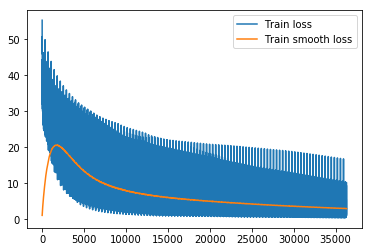

In [34]:
# Hyper-parameters
time_step = 10 # width, minibatch size and test sample size as well
num_layers = 1 # depth
n_iter = 100 # epochs
alpha = 1e-4 # learning_rate
print_after = 1 # n_iter//10 # print training loss, valid, and test
num_hidden_units = 64 # num_hidden_units in hidden layer
num_input_units = len(char_to_idx) # vocab_size = len(char_to_idx)
kernel_size = 5
num_kernels = 2
# Build the network and learning it or optimizing it using SGD
net = GRU(D=num_input_units, H=num_hidden_units, L=num_layers, K=kernel_size, N=num_kernels, char2idx=char_to_idx, 
          idx2char=idx_to_char)

# Start learning using BP-SGD-ADAM
adam_rnn(nn=net, X_train=X, y_train=y, alpha=alpha, mb_size=time_step, n_iter=n_iter, print_after=print_after)

# # Display the learning curve and losses for training, validation, and testing
# %matplotlib inline
# %config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

plt.plot(net.losses['train'], label='Train loss')
plt.plot(net.losses['smooth train'], label='Train smooth loss')
plt.legend()
plt.show()

Iter-1, train loss: 40.5456
Iter-2, train loss: 39.9089
Iter-3, train loss: 39.1447
Iter-4, train loss: 37.8713
Iter-5, train loss: 36.8586
Iter-6, train loss: 35.9333
Iter-7, train loss: 35.5973
Iter-8, train loss: 35.1981
Iter-9, train loss: 34.8897
Iter-10, train loss: 34.6289
Iter-11, train loss: 34.1124
Iter-12, train loss: 33.5370
Iter-13, train loss: 34.0461
Iter-14, train loss: 33.5594
Iter-15, train loss: 32.9339
Iter-16, train loss: 32.4307
Iter-17, train loss: 31.9029
Iter-18, train loss: 31.1605
Iter-19, train loss: 30.6188
Iter-20, train loss: 30.5539
Iter-21, train loss: 30.6413
Iter-22, train loss: 30.3380
Iter-23, train loss: 29.8773
Iter-24, train loss: 29.3505
Iter-25, train loss: 28.9094
Iter-26, train loss: 28.8371
Iter-27, train loss: 28.8524
Iter-28, train loss: 28.9082
Iter-29, train loss: 28.6560
Iter-30, train loss: 28.1740
Iter-31, train loss: 27.4803
Iter-32, train loss: 27.0752
Iter-33, train loss: 26.5280
Iter-34, train loss: 25.9245
Iter-35, train loss: 25

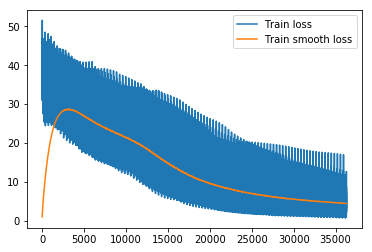

In [18]:
# # Hyper-parameters
# time_step = 10 # width, minibatch size and test sample size as well
# num_layers = 2 # depth
# n_iter = 100 # epochs
# alpha = 1e-4 # learning_rate
# print_after = 1 # n_iter//10 # print training loss, valid, and test
# num_hidden_units = 64 # num_hidden_units in hidden layer
# num_input_units = len(char_to_idx) # vocab_size = len(char_to_idx)
# kernel_size = 5

# # Build the network and learning it or optimizing it using SGD
# net = GRU(D=num_input_units, H=num_hidden_units, L=num_layers, char2idx=char_to_idx, idx2char=idx_to_char, 
#           K=kernel_size)

# # Start learning using BP-SGD-ADAM
# adam_rnn(nn=net, X_train=X, y_train=y, alpha=alpha, mb_size=time_step, n_iter=n_iter, print_after=print_after)

# # # Display the learning curve and losses for training, validation, and testing
# # %matplotlib inline
# # %config InlineBackend.figure_format = 'retina'
# import matplotlib.pyplot as plt

# plt.plot(net.losses['train'], label='Train loss')
# plt.plot(net.losses['smooth train'], label='Train smooth loss')
# plt.legend()
# plt.show()

Iter-1, train loss: 40.4260
Iter-2, train loss: 39.1128
Iter-3, train loss: 38.6397
Iter-4, train loss: 38.1203
Iter-5, train loss: 37.8425
Iter-6, train loss: 37.5355
Iter-7, train loss: 37.3439
Iter-8, train loss: 36.9753
Iter-9, train loss: 36.3471
Iter-10, train loss: 35.8969
Iter-11, train loss: 35.3930
Iter-12, train loss: 34.8545
Iter-13, train loss: 34.3204
Iter-14, train loss: 33.8005
Iter-15, train loss: 33.3448
Iter-16, train loss: 32.9013
Iter-17, train loss: 32.4649
Iter-18, train loss: 32.0623
Iter-19, train loss: 31.7075
Iter-20, train loss: 31.3557
Iter-21, train loss: 30.9653
Iter-22, train loss: 30.4230
Iter-23, train loss: 29.9423
Iter-24, train loss: 29.4755
Iter-25, train loss: 29.0498
Iter-26, train loss: 28.7334
Iter-27, train loss: 28.4455
Iter-28, train loss: 28.1554
Iter-29, train loss: 27.8887
Iter-30, train loss: 27.6097
Iter-31, train loss: 27.3345
Iter-32, train loss: 27.0712
Iter-33, train loss: 26.8112
Iter-34, train loss: 26.5386
Iter-35, train loss: 26

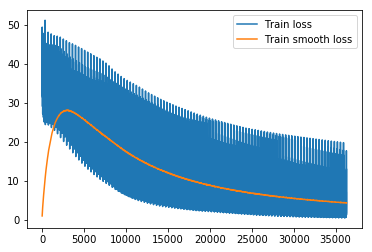

In [14]:
# # Hyper-parameters
# time_step = 10 # width, minibatch size and test sample size as well
# num_layers = 1 # depth
# n_iter = 100 # epochs
# alpha = 1e-4 # learning_rate
# print_after = 1 # n_iter//10 # print training loss, valid, and test
# num_hidden_units = 64 # num_hidden_units in hidden layer
# num_input_units = len(char_to_idx) # vocab_size = len(char_to_idx)
# kernel_size = 5

# # Build the network and learning it or optimizing it using SGD
# net = GRU(D=num_input_units, H=num_hidden_units, L=num_layers, char2idx=char_to_idx, idx2char=idx_to_char, 
#           K=kernel_size)

# # Start learning using BP-SGD-ADAM
# adam_rnn(nn=net, X_train=X, y_train=y, alpha=alpha, mb_size=time_step, n_iter=n_iter, print_after=print_after)

# # # Display the learning curve and losses for training, validation, and testing
# # %matplotlib inline
# # %config InlineBackend.figure_format = 'retina'
# import matplotlib.pyplot as plt

# plt.plot(net.losses['train'], label='Train loss')
# plt.plot(net.losses['smooth train'], label='Train smooth loss')
# plt.legend()
# plt.show()